In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve

assume normal distribution

96.56–104.97% (90% CI) AUC

81.68–95.13% (90% CI) geometric mean cipro/androcur

mean androcur=175ng/mL

mean ciproterone=150ng/mL

80-125% (90% CI) Cmax 

Cmax androcur calculations: 

ratio mu=0.88405,sigma=0.04088551

geom mean cipro,androcur: 162.019

In [2]:
def exp_cpa_decay(conc):
    if conc>100:
        return conc*0.5**(1/np.random.normal(loc=8,scale=1))
    elif conc>50:
        return conc*0.5**(1/np.random.normal(loc=32,scale=3))
    elif conc>20:
        return conc*0.5**(1/np.random.normal(loc=60,scale=12))
    else:
        return conc*0.8**(1/np.random.normal(loc=96,scale=24))

0.385058944585603 0.9075228681362235


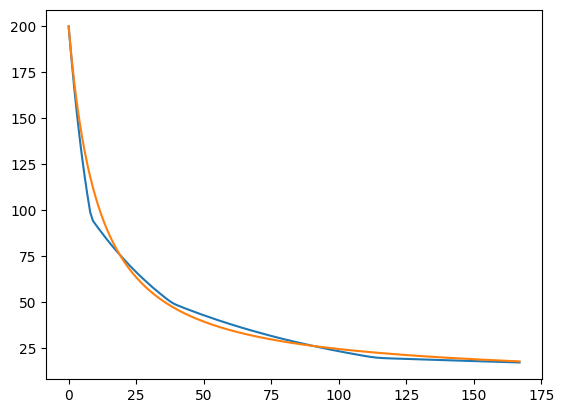

0.36161564817853026 0.9200395920482126


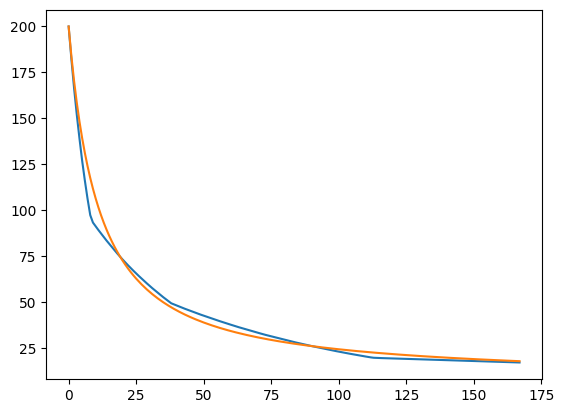

0.4133351292453029 0.8933562135890296


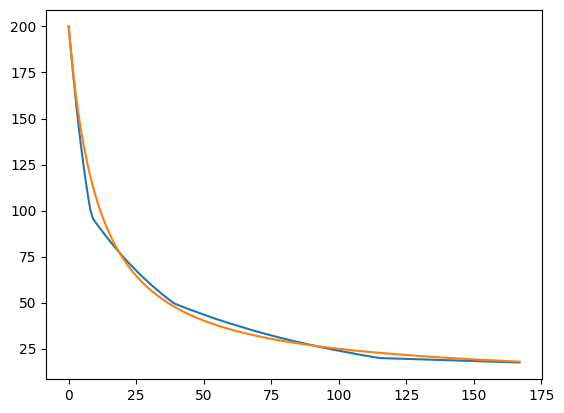

In [3]:
#checking cpa_decay
def testfunc(x,a,b):
    return 200*0.5**(x/(a*x**b+8))
    
lm=[]
for i in range(1000):
    l=[200]
    for j in range(167):
        l.append(exp_cpa_decay(l[-1]))
    lm.append(l.copy())
lmm=np.mean(np.array(lm),axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lmm)
plt.plot(np.arange(168),lmm)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm32=np.percentile(np.array(lm),32,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm32)
plt.plot(np.arange(168),lm32)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm68=np.percentile(np.array(lm),68,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm68)
plt.plot(np.arange(168),lm68)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

In [4]:
#fit function of d[cpa]/dt against [cpa]
def function(x,xx):
    a=0.386+0.0272*xx #fitted from piecewise function of exponentials, estimated std
    b=0.907-0.0141*xx
    return 200*0.5**(x/(a*x**b+8))

xs=np.arange(1,200,1)
xxs=np.arange(-2,2.01,0.01)

res=np.zeros((xs.shape[0],xxs.shape[0]))

for j,xx_value in enumerate(xxs):
    def diff(x,a):
        return (function(x,xx_value)-a)**2
    for i,x_value in enumerate(xs):
        res[i,j]=fsolve(diff, np.array(1.0), args=(x_value), xtol=1e-11, maxfev=2000)
np.save('inverseLUT.npy',res)

C:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
res=np.load('inverseLUT.npy')

In [6]:
res[100-1,200] #checking against https://www.desmos.com/calculator/roq7rjmjkp

11.551369578692753

In [7]:
def cpa_decay(conc):
    xx=np.clip(np.random.normal(),-2,2)
    ctime=np.interp([conc],np.arange(1,200,1),res[:,np.round(xx*100).astype(int)+200])
    return function(ctime+1,xx)

In [16]:
def simulate(dose,intervals,plot=True):
    repeat=sum(intervals)
    for i in range(len(intervals)-1,0,-1):
        intervals[i]=sum(intervals[:i+1])
    l=[dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5]
    for i in range(repeat*5):
        l.append(cpa_decay(l[-1]))
        if (i%repeat)+1 in intervals:
            l[-1]+=dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5
    if plot:
        plt.plot(np.arange(repeat*5+1)/24,l,'r',alpha=0.01)
    
    return [min(l),max(l),np.mean(l)],l

conservative estimate of unsafe dosage: 25mg/day

min,max,mean: (37.26690717169299, 107.7282828387695, 72.4945087102889)

comparison for side effects: intolerable for first 12h at 37.5mg

56.44ng/ml (97.5% confident that intolerable conc. was at least this)

In [29]:
def check(dose,intervals,steady=False):
    r=sum(intervals)
    checker=[]
    for i in range(100):
        m,l=simulate(dose,intervals.copy(),plot=(not steady))
        checker.append(l)
    if steady:
        plt.plot(np.arange(r)/24,np.percentile(checker,5,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.percentile(checker,95,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.mean(checker,axis=0)[-r:])
    plt.xlabel('Time (d)')
    plt.ylabel('CPA (ng/ml)')
    plt.title(str(dose)+' per '+str(intervals)+' hours')
    plt.show()
    #print(np.min(checker,axis=0),np.max(checker,axis=0),np.mean(checker,axis=0))

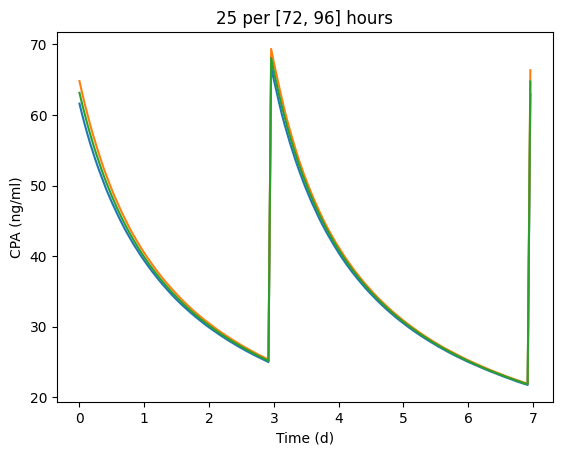

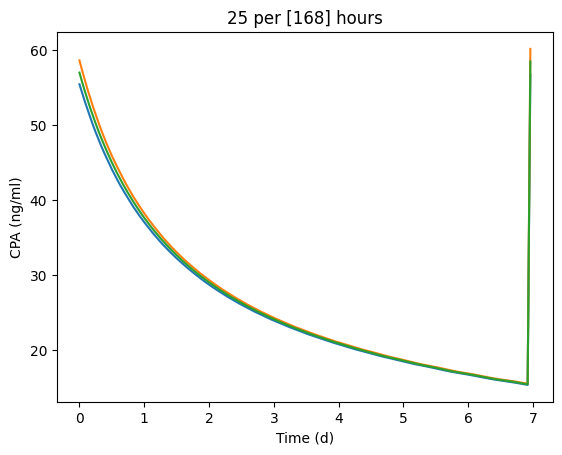

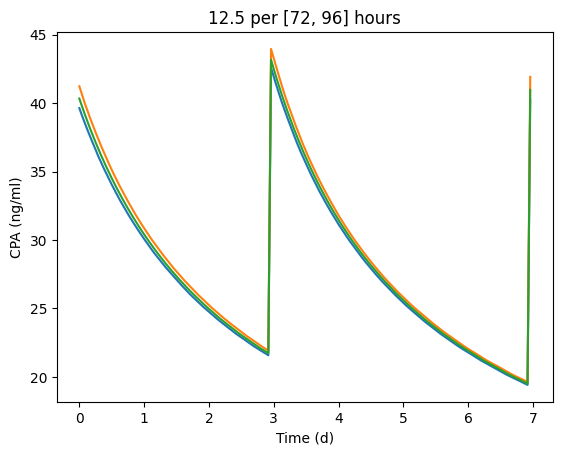

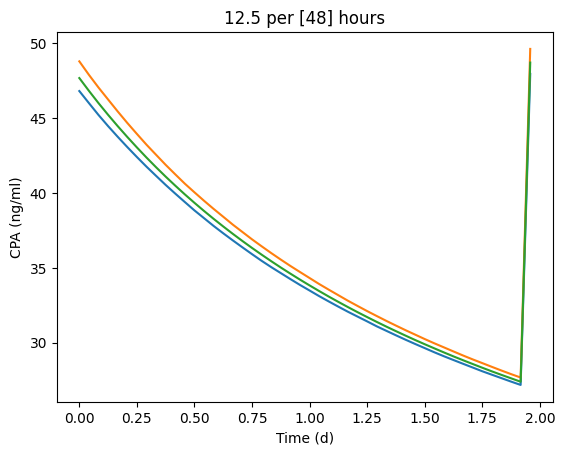

In [31]:
#25 every 3-4 days, side effects ;-;
check(25,[72,96],steady=True)

#25/week, too variable
check(25,[7*24],steady=True)

#12.5/3-4 days?
check(12.5,[72,96],steady=True)

#12.5/2 days (current)
check(12.5,[48],steady=True)